In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_colwidth", 200)

In [2]:
df = pd.read_csv('Combined_News_DJIA.csv')

In [3]:
df.tail()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
1984,2016-06-27,0,Barclays and RBS shares suspended from trading after tanking more than 8%,Pope says Church should ask forgiveness from gays for past treatment,Poland 'shocked' by xenophobic abuse of Poles in UK,"There will be no second referendum, cabinet agrees","Scotland welcome to join EU, Merkel ally says",Sterling dips below Friday's 31-year low amid Brexit uncertainty,No negative news about South African President allowed on state broadcaster.,Surge in Hate Crimes in the U.K. Following U.K.s Brexit Vote,...,German lawyers to probe Erdogan over alleged war crimes,"Boris Johnson says the UK will continue to ""intensify"" cooperation with the EU and tells his fellow Leave supporters they must accept the 52-48 referendum win was ""not entirely overwhelming"".",Richard Branson is calling on the UK government to hold a second EU referendum to prevent 'irreversible damage' to the country.,Turkey 'sorry for downing Russian jet',Edward Snowden lawyer vows new push for pardon from Obama,"Brexit opinion poll reveals majority don't want second EU referendum: ""half (48%) of British adults say that they are happy with the result, with two in five (43%) saying they are unhappy with the...","Conservative MP Leave Campaigner: ""The leave campaign don't have a post-Brexit plan...""","Economists predict UK recession, further weakening of Pound following Brexit.","New EU 'superstate plan by France, Germany: Creating a European superstate limiting the powers of individual members following Britains referendum decision to leave the EU",Pakistani clerics declare transgender marriages legal under Islamic law
1985,2016-06-28,1,"2,500 Scientists To Australia: If You Want To Save The Great Barrier Reef, Stop Supporting Coal","The personal details of 112,000 French police officers have been uploaded to Google Drive in a security breach just a fortnight after two officers were murdered at their home by a jihadist.",S&amp;P cuts United Kingdom sovereign credit rating to 'AA' from 'AAA',Huge helium deposit found in Africa,CEO of the South African state broadcaster quits shortly after negative news about president is banned.,"Brexit cost investors $2 trillion, the worst one day drop ever",Hong Kong democracy activists call for return to British rule as first step to independence,Brexit: Iceland president says UK can join 'triangle' of non-EU countries,...,"US, Canada and Mexico pledge 50% of power from clean energy by 2025","There is increasing evidence that Australia is torturing refugees, medical experts claim","Richard Branson, the founder of Virgin Group, said Tuesday that the company has lost about a third of its value since the U.K. voted to leave the European Union last week.","37,000-yr-old skull from Borneo reveals surprise for scientists - Study of the ""Deep Skull"" - oldest modern human discovered in SE Asia - reveals this ancient person was not related to Indigenous ...",Palestinians stone Western Wall worshipers; police shut Temple Mount to non-Muslims,Jean-Claude Juncker asks Farage: Why are you here?,"""Romanians for Remainians"" offering a new home to the 48% of Britons who voted to stay in the EU | Bucharest newspaper's app connects loving Romanian families with needy Brits, allowing people to ...",Brexit: Gibraltar in talks with Scotland to stay in EU,8 Suicide Bombers Strike Lebanon,Mexico's security forces routinely use 'sexual torture' against women: Rights group Amnesty International has compiled testimonies of sexual violence used as torture by Mexican security forces. De...
1986,2016-06-29,1,Explosion At Airport In Istanbul,Yemeni former president: Terrorism is the offspring of Wahhabism of Al Saud regime,UK must accept freedom of movement to access EU Market,Devastated: scientists too late to captive breed mammal lost to climate change - Australian conservationists spent 5 months obtaining permissions &amp; pl

In [4]:
df.shape

(1989, 27)

In [22]:
#fix nans
documents = []
for row in range(df.shape[0]):
    for col in range(2,27):
        if type(df.iloc[row,col])!=str:
            print(df.iloc[row,col])
            documents.append(" ")
        else:
            documents.append(df.iloc[row,col])
len(documents)

nan
nan
nan
nan
nan
nan
nan


49725

In [23]:
print(documents[0])

b"Georgia 'downs two Russian warplanes' as countries move to brink of war"


In [7]:
import pickle
stories = pickle.load(open('cnn_dataset.pkl', 'rb'))
print('Loaded Stories %d' % len(stories))

Loaded Stories 62912


In [8]:
documents = [" ".join(x['highlights']) for x in stories]

In [24]:
len(documents)

49725

In [120]:
news_df = pd.DataFrame({'document':documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")


# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>=4]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [121]:
news_df.head()

,document,clean_doc
0,"b""Georgia 'downs two Russian warplanes' as countries move to brink of war""",georgia downs russian warplanes countries move brink
1,b'BREAKING: Musharraf to be impeached.',breaking musharraf impeached
2,b'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)',russia today columns troops roll into south ossetia footage from fighting youtube
3,"b'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire'",russian tanks moving towards capital south ossetia which reportedly been completely destroyed georgian artillery fire
4,"b""Afghan children raped with 'impunity,' U.N. official says - this is sick, a three year old was raped and they do nothing""",afghan children raped with impunity official says this sick three year raped they nothing


In [122]:
len(news_df)

49725

In [123]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

In [124]:
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
class StemTokenizer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer("english")
    def __call__(self,doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc)]

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(#stop_words='english', 
#tokenizer=StemTokenizer(),
max_features= 10000, # keep top 10000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape # check shape of the document-term matrix

(49725, 10000)

In [126]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

10

In [127]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    #print(terms_comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": "+ " ".join([t[0] for t in sorted_terms]))
    for t in sorted_terms:
        pass
        #print(t[0])
        #print(" ")

Topic 0: says israel korea north china russia world iran police people
Topic 1: korea north south korean nuclear jong china test missile japan
Topic 2: israel gaza israeli palestinian korea hamas north iran palestinians west
Topic 3: russia says ukraine iran putin russian syria nuclear israel military
Topic 4: china world israel japan chinese first nuclear iran india bank
Topic 5: iran world nuclear says first saudi minister news arabia years
Topic 6: world russia first ukraine israel gaza bank putin says government
Topic 7: says minister china prime government rights human report snowden must
Topic 8: police israel russia government protesters anti court protest arrested officers
Topic 9: police world says killed news attack protesters people iran pakistan


In [128]:
#Get params and see which topics are high for specific articles, 
comps = svd_model.components_

n,d = X.shape #Featurized articles
topic_scores = np.hstack([comps@X[i:i+1,:].T for i in range(n)])
topic_scores.shape

(10, 49725)

In [129]:
#Now let's average out those scores over the surrounding 1000 articles scores to see how average scores change over time
d,n = topic_scores.shape
averages = []
i=0
start = 2008
end = 2016
dates = []
while(i<n):
    running_sum = topic_scores[:,i:i+1]
    i+=1
    count = 0
    while (i)%1000 != 0:
        running_sum = running_sum + topic_scores[:,i:i+1]
        i+=1
        count+=1
    averages.append(running_sum/count)
    dates.append(start + (end-start)*i/n)
    

In [130]:
averages = np.hstack(average for average in averages)
averages.shape

(10, 49)

[]

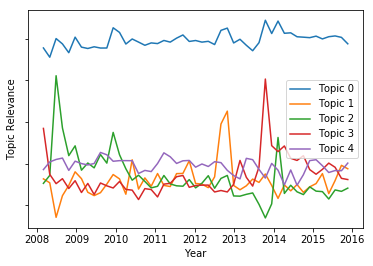

In [131]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1)
ax.plot(dates[:-1],averages[0:5,:].T)
ax.legend(["Topic "+str(i) for i in range(averages.shape[0])])
ax.set_xlabel("Year")
ax.set_ylabel("Topic Relevance")
ax.set_yticklabels([])

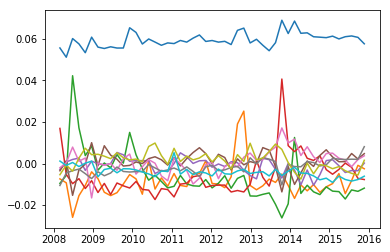

In [132]:
plt.plot(dates[:-1],averages.T)

In [36]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
lda = LatentDirichletAllocation(n_components=10, random_state=0)

In [66]:
lda.fit(X) 

c:\python36\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [67]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(lda.components_):
    terms_comp = zip(terms, comp)
    #print(terms_comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": "+ " ".join([t[0] for t in sorted_terms]))
    for t in sorted_terms:
        pass
        #print(t[0])
        #print(" ")

Topic 0: little course vicentes went bonnienorman talk later
Topic 1: article mins awesome articles arrived https great
Topic 2: short https hyperloop powered http wrong love
Topic 3: yeah sure change climate https great definitely
Topic 4: cool house improvements https minor regarding games
Topic 5: work westcoastbill transport mass univ direct spaceship
Topic 6: http https tesla spacex launch model falcon
Topic 7: exactly need hopefully true tregner thomas https
Topic 8: interesting elonmusk https problem view faster jovanik
Topic 9: http https long really boring wired gets


In [68]:
#Get params and see which topics are high for specific articles, 
comps = lda.components_

n,d = X.shape #Featurized articles
topic_scores = np.hstack([comps@X[i:i+1,:].T for i in range(n)])
topic_scores.shape

(10, 3218)

In [78]:
#Now let's average out those scores over the surrounding 1000 articles scores to see how average scores change over time
d,n = topic_scores.shape
averages = []
i=0
start = 2008
end = 2016
dates = []
while(i<n):
    running_sum = topic_scores[:,i:i+1]
    i+=1
    count = 0
    while (i)%500 != 0:
        running_sum = running_sum + topic_scores[:,i:i+1]
        i+=1
        count+=1
    averages.append(running_sum/count)
    dates.append(start + (end-start)*i/n)

In [79]:
averages = np.hstack(average for average in averages)
averages.shape

(10, 6)

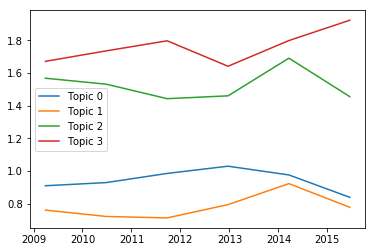

In [80]:
import matplotlib.pyplot as plt
plt.plot(dates[:-1],averages[:4,:].T)
plt.legend(["Topic "+str(i) for i in range(averages.shape[0])])